Dieses Notebook soll dafür dienen zu schauen, wie gut die Trading Strategie mit dem vorhergesagten ID3 Preis funktioniert. Wir kaufen alles, was unter unserem ID3 Preis liegt und verkaufen alles, was über diesem liegt. Disclaimer: dies wird in der Praxis nicht so gemacht, da man nur eine bestimmte Menge kaufen muss. Aus einfachheitsgründen wird dies hier aber so gemacht.

In [1]:
# Import important libraries
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/self_created_python_packages')
import numpy as np
import sqlite3
import pandas as pd
from tqdm import tqdm
import sqlite3
import matplotlib.pyplot as plt
from database_functions import connect_to_database, write_dataframe_to_database

Mounted at /content/drive


In [2]:
def get_DataFrame_from_SQL_database(cursor, table_name, limit = 0):
  """
  Function to get dataframe from sql database
  """
  query = f'SELECT * FROM {table_name}'

  if limit > 0:
    query = query + f' LIMIT {limit}'

  cursor.execute(query)
  rows = cursor.fetchall()
  columns = [column[0] for column in cursor.description]

  return pd.DataFrame(rows, columns=columns)

## Regression

In [3]:
def get_best_model(result_df):
  """
  Function to get the best model based on the different hyperparameters for Regression methods (MAE etc. are only valid for regression)
  """
  best_models = pd.DataFrame(columns = ['H', 'test_size', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'MAE', 'MAPE','MSE'])
  for H in [2,3]:
    results_df_H = result_df[result_df['H'] == H]

    # Finden des Index mit dem niedrigsten MAE
    index_lowest_mae = results_df_H['MAE'].idxmin()

    pre_df = pd.DataFrame({'H':H, 'test_size':[result_df.loc[index_lowest_mae, 'test_size']], 'n_estimators':[result_df.loc[index_lowest_mae, 'n_estimators']], 'max_depth':[result_df.loc[index_lowest_mae, 'max_depth']],
                           'min_samples_split':[result_df.loc[index_lowest_mae, 'min_samples_split']], 'min_samples_leaf' : [result_df.loc[index_lowest_mae, 'min_samples_leaf']], 'MAE':[result_df.loc[index_lowest_mae, 'MAE']], 'MAPE':[result_df.loc[index_lowest_mae, 'MAPE']], 'MSE':[result_df.loc[index_lowest_mae, 'MSE']]})

    best_models = pd.concat([best_models, pre_df], ignore_index = True)

  return best_models.reset_index(drop = True)


In [16]:
def get_best_models(format, ordner_link, RF_OR_BT):
    """
    Function to iterate through the different train methods (train on weekdays, hours, weekdays + hours). Get the best model for each of the train method and concatenate them together.

    Input:
    format: String specifying the training format ('weekdays', 'hours', or 'weekdays_hours').
    ordner_link: Path to the folder containing the database files.
    RF_OR_BT: String specifying the model type ('RF' for Random Forest or 'BT' for Boosted Trees).

    Output:
    A DataFrame containing the best models for each training format.
    """

    # Define format arrays based on the format parameter
    if format == 'weekdays':
        format_array = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    elif format == 'hours':
        format_array = ["0_h", "1_h", "2_h", "3_h", "4_h", "5_h", "6_h", "7_h", "8_h", "9_h", "10_h", "11_h", "12_h",
                        "13_h", "14_h", "15_h", "16_h", "17_h", "18_h", "19_h", "20_h", "21_h", "22_h", "23_h"]
    elif format == 'weekdays_hours':
        format_array = ["Monday_0_h", "Monday_1_h", "Monday_2_h", "Monday_3_h", "Monday_4_h", "Monday_5_h", "Monday_6_h",
                        "Monday_7_h", "Monday_8_h", "Monday_9_h", "Monday_10_h", "Monday_11_h", "Monday_12_h", "Monday_13_h",
                        "Monday_14_h", "Monday_15_h", "Monday_16_h", "Monday_17_h", "Monday_18_h", "Monday_19_h", "Monday_20_h",
                        "Monday_21_h", "Monday_22_h", "Monday_23_h", "Tuesday_0_h", "Tuesday_1_h", "Tuesday_2_h", "Tuesday_3_h",
                        "Tuesday_4_h", "Tuesday_5_h", "Tuesday_6_h", "Tuesday_7_h", "Tuesday_8_h", "Tuesday_9_h", "Tuesday_10_h",
                        "Tuesday_11_h", "Tuesday_12_h", "Tuesday_13_h", "Tuesday_14_h", "Tuesday_15_h", "Tuesday_16_h", "Tuesday_17_h",
                        "Tuesday_18_h", "Tuesday_19_h", "Tuesday_20_h", "Tuesday_21_h", "Tuesday_22_h", "Tuesday_23_h", "Wednesday_0_h",
                        "Wednesday_1_h", "Wednesday_2_h", "Wednesday_3_h", "Wednesday_4_h", "Wednesday_5_h", "Wednesday_6_h",
                        "Wednesday_7_h", "Wednesday_8_h", "Wednesday_9_h", "Wednesday_10_h", "Wednesday_11_h", "Wednesday_12_h",
                        "Wednesday_13_h", "Wednesday_14_h", "Wednesday_15_h", "Wednesday_16_h", "Wednesday_17_h", "Wednesday_18_h",
                        "Wednesday_19_h", "Wednesday_20_h", "Wednesday_21_h", "Wednesday_22_h", "Wednesday_23_h", "Thursday_0_h",
                        "Thursday_1_h", "Thursday_2_h", "Thursday_3_h", "Thursday_4_h", "Thursday_5_h", "Thursday_6_h", "Thursday_7_h",
                        "Thursday_8_h", "Thursday_9_h", "Thursday_10_h", "Thursday_11_h", "Thursday_12_h", "Thursday_13_h", "Thursday_14_h",
                        "Thursday_15_h", "Thursday_16_h", "Thursday_17_h", "Thursday_18_h", "Thursday_19_h", "Thursday_20_h", "Thursday_21_h",
                        "Thursday_22_h", "Thursday_23_h", "Friday_0_h", "Friday_1_h", "Friday_2_h", "Friday_3_h", "Friday_4_h", "Friday_5_h",
                        "Friday_6_h", "Friday_7_h", "Friday_8_h", "Friday_9_h", "Friday_10_h", "Friday_11_h", "Friday_12_h", "Friday_13_h",
                        "Friday_14_h", "Friday_15_h", "Friday_16_h", "Friday_17_h", "Friday_18_h", "Friday_19_h", "Friday_20_h", "Friday_21_h",
                        "Friday_22_h", "Friday_23_h", "Saturday_0_h", "Saturday_1_h", "Saturday_2_h", "Saturday_3_h", "Saturday_4_h",
                        "Saturday_5_h", "Saturday_6_h", "Saturday_7_h", "Saturday_8_h", "Saturday_9_h", "Saturday_10_h", "Saturday_11_h",
                        "Saturday_12_h", "Saturday_13_h", "Saturday_14_h", "Saturday_15_h", "Saturday_16_h", "Saturday_17_h", "Saturday_18_h",
                        "Saturday_19_h", "Saturday_20_h", "Saturday_21_h", "Saturday_22_h", "Saturday_23_h", "Sunday_0_h", "Sunday_1_h",
                        "Sunday_2_h", "Sunday_3_h", "Sunday_4_h", "Sunday_5_h", "Sunday_6_h", "Sunday_7_h", "Sunday_8_h", "Sunday_9_h",
                        "Sunday_10_h", "Sunday_11_h", "Sunday_12_h", "Sunday_13_h", "Sunday_14_h", "Sunday_15_h", "Sunday_16_h", "Sunday_17_h",
                        "Sunday_18_h", "Sunday_19_h", "Sunday_20_h", "Sunday_21_h", "Sunday_22_h", "Sunday_23_h"]

    # Iterate through the format array
    for arr in format_array:
        print(arr)
        if arr == 'Sunday_9_h' and RF_OR_BT == 'RF':
          continue # hier ist kurz vor abgabe ein database disk image fehler aufgetreten, man müsste
          # das modell einfach nochmal durchlaufen lassen bzw auf einem server mit mehr rechenkapa arbeiten
        # Connect to the database for the current format
        [conn_rf_regr_, cur_rf_regr_] = connect_to_database(f'{RF_OR_BT}_Regression_test_format_string_{arr}.db', path=ordner_link)

        # Retrieve the results from the database
        results = get_DataFrame_from_SQL_database(cur_rf_regr_, 'results_error')

        # Get the best model from the results
        best_model_df = get_best_model(results)

        # Add the current format to the best model DataFrame
        best_model_df[format] = arr

        # Concatenate the best model DataFrame to the final DataFrame
        if arr == format_array[0]:
            final_df = best_model_df
        else:
            final_df = pd.concat([final_df, best_model_df], ignore_index=True)

    # Return the final DataFrame with the best models
    return final_df.reset_index(drop=True)



def get_predictions(cursor, dict_hyperparameter):
    """
    Function to get the predicted values from the specific "best" model, based on the specific hyperparameters.

    Input:
    cursor: Database cursor used for querying the database.
    dict_hyperparameter: A dictionary containing the hyperparameters used to identify the best model.
        - H: Hyperparameter H
        - test_size: Test size proportion
        - n_estimators: Number of trees in the forest
        - max_depth: Maximum depth of the trees
        - min_samples_split: Minimum number of samples required to split an internal node
        - min_samples_leaf: Minimum number of samples required to be at a leaf node

    Output:
    A DataFrame containing the real and predicted values for ID3.
    """

    # Extract hyperparameters from the dictionary
    H = dict_hyperparameter['H']
    test_size = dict_hyperparameter['test_size']
    n_estimators = dict_hyperparameter['n_estimators']
    max_depth = dict_hyperparameter['max_depth']
    min_samples_split = int(dict_hyperparameter['min_samples_split'])
    min_samples_leaf = int(dict_hyperparameter['min_samples_leaf'])

    # Convert max_depth to the corresponding string
    if max_depth == 'None':
        max_depth_name = 'None'
    else:
        max_depth_name = int(max_depth)

    # Convert the float test_size to a string
    float_str = str(test_size)

    # Extract the last digit after the decimal point
    last_digit = int(float_str.split('.')[-1][-1])

    # Generate the table name based on the hyperparameters
    table_name = (f'Table_H_{H}_test_size_{str(last_digit)}_n_estimators_{str(int(n_estimators))}_'
                  f'max_depth_name_{str(max_depth_name)}_min_samples_split_{str(min_samples_split)}_'
                  f'min_samples_leaf_{str(min_samples_leaf)}_ypred')

    # Retrieve the data from the SQL database and filter the columns 'real_ID3' and 'pred_ID3'
    return get_DataFrame_from_SQL_database(cursor, table_name)[['real_ID3', 'pred_ID3']]


## Classification

In [13]:
def get_best_model_classification(result_df):
    """
    Function to get the best model for classification based on accuracy for each value of H.

    Input:
    result_df: DataFrame containing the results of the models with columns ['H', 'test_size', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy'].

    Output:
    A DataFrame containing the best models based on accuracy.
    """
    best_models = pd.DataFrame(columns=['H', 'test_size', 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'accuracy'])

    for H in [3]:
        # Filter the DataFrame for the current H value
        results_df_H = result_df[result_df['H'] == H]

        # Find the index of the row with the highest accuracy
        index_highest_accuracy = results_df_H['accuracy'].idxmax()

        # Create a DataFrame for the best model for the current H value
        pre_df = pd.DataFrame({
            'H': [H],
            'test_size': [result_df.loc[index_highest_accuracy, 'test_size']],
            'n_estimators': [result_df.loc[index_highest_accuracy, 'n_estimators']],
            'max_depth': [result_df.loc[index_highest_accuracy, 'max_depth']],
            'min_samples_split': [result_df.loc[index_highest_accuracy, 'min_samples_split']],
            'min_samples_leaf': [result_df.loc[index_highest_accuracy, 'min_samples_leaf']],
            'accuracy': [result_df.loc[index_highest_accuracy, 'accuracy']]
        })

        # Concatenate the best model DataFrame to the best models DataFrame
        best_models = pd.concat([best_models, pre_df], ignore_index=True)

    # Return the best models DataFrame
    return best_models.reset_index(drop=True)

# analog to get_best_models

def get_best_models_classification(format, ordner_link_classification = '/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/DecisionTreeRules/RandomForest/Classification'):
  if format == 'weekdays':
    format_array = ['Monday', 'Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  elif format == 'hours':
    format_array = ["0_h",	"1_h",	"2_h",	"3_h",	"4_h",	"5_h",	"6_h",	"7_h",	"8_h",	"9_h",	"10_h",	"11_h",	"12_h",	"13_h",	"14_h",	"15_h",	"16_h",	"17_h",	"18_h",	"19_h",	"20_h",	"21_h",	"22_h",	"23_h"]
  elif format == 'weekdays_hours':
    format_array = ["Monday_0_h",	"Monday_1_h",	"Monday_2_h",	"Monday_3_h",	"Monday_4_h",	"Monday_5_h",	"Monday_6_h",	"Monday_7_h",	"Monday_8_h",	"Monday_9_h",	"Monday_10_h",	"Monday_11_h",	"Monday_12_h",	"Monday_13_h",	"Monday_14_h",	"Monday_15_h",	"Monday_16_h",	"Monday_17_h",	"Monday_18_h",	"Monday_19_h",	"Monday_20_h",	"Monday_21_h",	"Monday_22_h",	"Monday_23_h",
                    "Tuesday_0_h",	"Tuesday_1_h",	"Tuesday_2_h",	"Tuesday_3_h",	"Tuesday_4_h",	"Tuesday_5_h",	"Tuesday_6_h",	"Tuesday_7_h",	"Tuesday_8_h",	"Tuesday_9_h",	"Tuesday_10_h",	"Tuesday_11_h",	"Tuesday_12_h",	"Tuesday_13_h",	"Tuesday_14_h",	"Tuesday_15_h",	"Tuesday_16_h",	"Tuesday_17_h",	"Tuesday_18_h",	"Tuesday_19_h",	"Tuesday_20_h",	"Tuesday_21_h",	"Tuesday_22_h",	"Tuesday_23_h",
                    "Wednesday_0_h",	"Wednesday_1_h",	"Wednesday_2_h",	"Wednesday_3_h",	"Wednesday_4_h",	"Wednesday_5_h",	"Wednesday_6_h",	"Wednesday_7_h",	"Wednesday_8_h",	"Wednesday_9_h",	"Wednesday_10_h",	"Wednesday_11_h",	"Wednesday_12_h",	"Wednesday_13_h",	"Wednesday_14_h",	"Wednesday_15_h",	"Wednesday_16_h",	"Wednesday_17_h",	"Wednesday_18_h",	"Wednesday_19_h",	"Wednesday_20_h",	"Wednesday_21_h",	"Wednesday_22_h",	"Wednesday_23_h",
                    "Thursday_0_h",	"Thursday_1_h",	"Thursday_2_h",	"Thursday_3_h",	"Thursday_4_h",	"Thursday_5_h",	"Thursday_6_h",	"Thursday_7_h",	"Thursday_8_h",	"Thursday_9_h",	"Thursday_10_h",	"Thursday_11_h",	"Thursday_12_h",	"Thursday_13_h",	"Thursday_14_h",	"Thursday_15_h",	"Thursday_16_h",	"Thursday_17_h",	"Thursday_18_h",	"Thursday_19_h",	"Thursday_20_h",	"Thursday_21_h",	"Thursday_22_h",	"Thursday_23_h",
                    "Friday_0_h",	"Friday_1_h",	"Friday_2_h",	"Friday_3_h",	"Friday_4_h",	"Friday_5_h",	"Friday_6_h",	"Friday_7_h",	"Friday_8_h",	"Friday_9_h",	"Friday_10_h",	"Friday_11_h",	"Friday_12_h",	"Friday_13_h",	"Friday_14_h",	"Friday_15_h",	"Friday_16_h",	"Friday_17_h",	"Friday_18_h",	"Friday_19_h",	"Friday_20_h",	"Friday_21_h",	"Friday_22_h",	"Friday_23_h",
                    "Saturday_0_h",	"Saturday_1_h",	"Saturday_2_h",	"Saturday_3_h",	"Saturday_4_h",	"Saturday_5_h",	"Saturday_6_h",	"Saturday_7_h",	"Saturday_8_h",	"Saturday_9_h",	"Saturday_10_h",	"Saturday_11_h",	"Saturday_12_h",	"Saturday_13_h",	"Saturday_14_h",	"Saturday_15_h",	"Saturday_16_h",	"Saturday_17_h",	"Saturday_18_h",	"Saturday_19_h",	"Saturday_20_h",	"Saturday_21_h",	"Saturday_22_h",	"Saturday_23_h",
                    "Sunday_0_h",	"Sunday_1_h",	"Sunday_2_h",	"Sunday_3_h",	"Sunday_4_h",	"Sunday_5_h",	"Sunday_6_h",	"Sunday_7_h",	"Sunday_8_h",	"Sunday_9_h",	"Sunday_10_h",	"Sunday_11_h",	"Sunday_12_h",	"Sunday_13_h",	"Sunday_14_h",	"Sunday_15_h",	"Sunday_16_h",	"Sunday_17_h",	"Sunday_18_h",	"Sunday_19_h",	"Sunday_20_h",	"Sunday_21_h",	"Sunday_22_h",	"Sunday_23_h"]
  for arr in format_array:
    print(arr)
    if arr == "Sunday_0_h" :
      continue
    [conn_rf_clf_, cur_rf_clf_] = connect_to_database(f'RF_Classification_testformat_{arr}.db', path = ordner_link_classification)

    results = get_DataFrame_from_SQL_database(cur_rf_clf_, 'Quantile_results_error')

    best_model_df = get_best_model_classification(results)

    best_model_df[format] = arr

    if arr == format_array[0]:
      final_df = best_model_df
    else:
      final_df = pd.concat([final_df, best_model_df], ignore_index = True)

  return final_df.reset_index(drop = True)


## Now we want to join the predictions to the actual trading orders so we can estimate the profit

In [6]:
def get_DataFrame_from_SQL_database_timeseries(cursor, table_name, startDate_formatted, endDate_formatted, limit=0, nullvalues=False):
    """
    Retrieve a DataFrame from an SQL database for a specific timespan.

    Input:
    cursor: The database cursor.
    table_name: The name of the table to query.
    startDate_formatted: The start date of the timespan.
    endDate_formatted: The end date of the timespan.
    limit: Optional. The maximum number of rows to retrieve.
    nullvalues: Boolean indicating whether to include rows with null values.

    Output:
    A DataFrame containing the queried data.
    """
    # Construct the query based on whether null values should be included
    if not nullvalues:
        query = f'SELECT * FROM {table_name}_{startDate_formatted}_{endDate_formatted}'
    else:
        query = f'SELECT * FROM {table_name}_{startDate_formatted}_{endDate_formatted}_NO_NULLVALUES'

    # Add a LIMIT clause to the query if a limit is specified
    if limit > 0:
        query += f' LIMIT {limit}'

    # Execute the query and fetch the results
    cursor.execute(query)
    rows = cursor.fetchall()
    columns = [column[0] for column in cursor.description]

    # Return the results as a DataFrame
    return pd.DataFrame(rows, columns=columns)

def get_trading_df_from_SQL_database(cursor, table_name, startDate_formatted, endDate_formatted, limit=0, nullvalues=False):
    """
    Retrieve a trading DataFrame from an SQL database for a specific timespan, filtered by contract name.

    Input:
    cursor: The database cursor.
    table_name: The name of the table to query.
    startDate_formatted: The start date of the timespan.
    endDate_formatted: The end date of the timespan.
    limit: Optional. The maximum number of rows to retrieve.
    nullvalues: Boolean indicating whether to include rows with null values.

    Output:
    A DataFrame containing the queried trading data.
    """
    # Construct the query based on whether null values should be included and filter by contract name
    if not nullvalues:
        query = f'SELECT * FROM {table_name}_{startDate_formatted}_{endDate_formatted} WHERE contractName LIKE "PH%"'
    else:
        query = f'SELECT * FROM {table_name}_{startDate_formatted}_{endDate_formatted}_NO_NULLVALUES'

    # Add a LIMIT clause to the query if a limit is specified
    if limit > 0:
        query += f' LIMIT {limit}'

    # Execute the query and fetch the results
    cursor.execute(query)
    rows = cursor.fetchall()
    columns = [column[0] for column in cursor.description]

    # Return the results as a DataFrame
    return pd.DataFrame(rows, columns=columns)

def get_timeseries(cursor, orig_query):
    """
    Retrieve a time series DataFrame from an SQL database based on a given query.

    Input:
    cursor: The database cursor.
    orig_query: The original SQL query to execute.

    Output:
    A DataFrame containing the queried time series data.
    """
    # Execute the query and fetch the results
    cursor.execute(orig_query)
    rows = cursor.fetchall()
    columns = [column[0] for column in cursor.description]

    # Create a DataFrame from the results
    df = pd.DataFrame(rows, columns=columns)

    # Replace infinite values with 0 and drop rows with any NaN values
    df = df.replace([np.inf, -np.inf], 0)
    df = df.dropna(how='any')

    # Return the cleaned DataFrame
    return df

def get_query_timeseries(H, window_size_rolling_window=3):
    return f'''
      SELECT
        da_prc.date, da_prc.YEAR, da_prc.WEEKDAY, da_prc.MONTH, da_prc.HOUR, da_prc.DUMMY_WEEKDAY, da_prc.DA_PRC_DAY_BEFORE, da_prc.DA_AV_PRC_3_DAYS, da_prc.DA_PRC_SAME_DAY,
        da_vol.DA_VOL_DAY_BEFORE, da_vol.DA_VOL_SAME_DAY, da_vol.DA_AV_VOL_3_DAYS,
        pl_pr.PL_PR_TOTAL, pl_pr.PL_PR_GAS, pl_pr.PL_PR_WIND, pl_pr.PL_PR_LIGNITE, pl_pr.PL_PR_BC, pl_pr.PL_PR_IC, pl_pr.PL_PR_OIL, pl_pr.PL_PR_GEO, pl_pr.PL_PR_HYDRO, pl_pr.PL_PR_NAPHTA, pl_pr.PL_PR_BIO, pl_pr.PL_PR_RIVER, pl_pr.PL_PR_OTHER,
        pr_inj.INJ_SUN_{H}_h, pr_inj.INJ_ASPHAL_{H}_h, pr_inj.INJ_LNG_{H}_h, pr_inj.INJ_II_{H}_h, pr_inj.INJ_IE_{H}_h,
        pr_inj.DIFFERENZ_PR_INJ_TOTAL_{H}_h, pr_inj.DIFFERENZ_PR_INJ_GAS_{H}_h, pr_inj.DIFFERENZ_PR_INJ_WIND_{H}_h, pr_inj.DIFFERENZ_PR_INJ_LIGNITE_{H}_h, pr_inj.DIFFERENZ_PR_INJ_BC_{H}_h, pr_inj.DIFFERENZ_PR_INJ_IC_{H}_h, pr_inj.DIFFERENZ_PR_INJ_OIL_{H}_h, pr_inj.DIFFERENZ_PR_INJ_GEO_{H}_h, pr_inj.DIFFERENZ_PR_INJ_HYDRO_{H}_h, pr_inj.DIFFERENZ_PR_INJ_NAPHTA_{H}_h, pr_inj.DIFFERENZ_PR_INJ_BIO_{H}_h, pr_inj.DIFFERENZ_PR_INJ_RIVER_{H}_h, pr_inj.DIFFERENZ_PR_INJ_OTHER_{H}_h,
        pr_inj_rw.ROLLING_WINDOW_INJ_SUN_{H}_h, pr_inj_rw.ROLLING_WINDOW_INJ_ASPHAL_{H}_h, pr_inj_rw.ROLLING_WINDOW_INJ_LNG_{H}_h, pr_inj_rw.ROLLING_WINDOW_INJ_II_{H}_h, pr_inj_rw.ROLLING_WINDOW_INJ_IE_{H}_h,
        pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_TOTAL_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_GAS_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_WIND_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_LIGNITE_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_BC_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_IC_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_OIL_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_GEO_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_HYDRO_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_NAPHTA_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_BIO_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_RIVER_{H}_h, pr_inj_rw.ROLLING_WINDOW_DIFFERENZ_PR_INJ_OTHER_{H}_h,
        for_load.FORECAST_LOAD_SAME_DAY,
        for_load_rw.ROLLING_WINDOW_PAST_{window_size_rolling_window}_h_DIFFERENZ_FOR_REAL_LOAD_{H}_h,
        sys_dir.SYSTEM_DIRECTION_{H}_h, sys_dir.ROLLING_WINDOW_PAST_{window_size_rolling_window}_h_SYSTEM_DIRECTION_{H}_h,
        up_reg.UP_REG_{H}_h_0, up_reg.UP_REG_{H}_h_1, up_reg.UP_REG_{H}_h_2,
        down_reg.DOWN_REG_{H}_h_0, down_reg.DOWN_REG_{H}_h_1, down_reg.DOWN_REG_{H}_h_2,
        fi_pl.PL_FI_LOAD,
        fi_unpl.UNPL_FI_LOAD_{H}_h, fi_unpl.ROLLING_WINDOW_PAST_{window_size_rolling_window}_h_UNPL_FI_LOAD_{H}_h,
        fi_pow.POWER_FI_{H}_h, fi_pow.ROLLING_WINDOW_PAST_{window_size_rolling_window}_h_POWER_FI_{H}_h,
        wpp.DIFF_FOR_GEN_WPP_{H}_h, wpp.GENERATION_WPP_{H}_h, wpp.FORECAST_WPP,
        tr.TRADE_COUNT_{H}_h, tr.TRADE_VOLATILITY_{H}_h, tr.TRADE_VOLUME_{H}_h, tr.PRE_ID3_{H}_h, tr.AV_TRADE_COUNT_{H}_h, tr.AV_TRADE_VOLATILITY_{H}_h, tr.AV_TRADE_VOLUME_{H}_h, tr.AV_PRE_ID3_{H}_h,
        id.ID3_FILLED
      FROM
        DA_PRC_timeseries da_prc
      LEFT JOIN
        DA_VOL_timeseries da_vol
      ON
        da_prc.date = da_vol.date
      LEFT JOIN
        PLANNED_PR_timeseries pl_pr
      ON
        da_prc.date = pl_pr.date
      LEFT JOIN
        PROD_INJ_timeseries pr_inj
      ON
        da_prc.date = pr_inj.date
      LEFT JOIN
        PROD_INJ_RW_timeseries pr_inj_rw
      ON
        da_prc.date = pr_inj_rw.date
      LEFT JOIN
        FOR_LOAD_timeseries for_load
      ON
        da_prc.date = for_load.date
      LEFT JOIN
        FOR_REAL_LOAD_RW_timeseries for_load_rw
      ON
        da_prc.date = for_load_rw.date
      LEFT JOIN
        SYSTEM_DIRECTION_timeseries sys_dir
      ON
        da_prc.date = sys_dir.date
      LEFT JOIN
        UP_REG_timeseries up_reg
      ON
        da_prc.date = up_reg.date
      LEFT JOIN
        DOWN_REG_timeseries down_reg
      ON
        da_prc.date = down_reg.date
      LEFT JOIN
        FI_PL_LOAD_timeseries fi_pl
      ON
        da_prc.date = fi_pl.date
      LEFT JOIN
        FI_UNPL_LOAD_timeseries fi_unpl
      ON
        da_prc.date = fi_unpl.date
      LEFT JOIN
        FI_POWER_timeseries fi_pow
      ON
        da_prc.date = fi_pow.date
      LEFT JOIN
        WPP_timeseries wpp
      ON
        da_prc.date = wpp.date
      LEFT JOIN
        TRADING_DATA_{H}_timeseries tr
      ON
        da_prc.date = tr.date
      LEFT JOIN
        ID_PRICES_timeseries id
      ON
        da_prc.date = id.date
      '''



To join the predictions at the trading orders, we have to extract the dates from the trading orders, so we can use it as a left join later

In [7]:
def add_date(pred_df, timeseries_orig):
    """
    Add date information to the prediction DataFrame based on the original timeseries DataFrame.

    Input:
    pred_df: DataFrame containing predictions with a column 'real_ID3'.
    timeseries_orig: Original timeseries DataFrame with columns 'ID3_filled' and 'date'.

    Output:
    Merged DataFrame with added date information.
    """
    pred_df['ID3_filled'] = pred_df['real_ID3']
    merged_df = pd.merge(pred_df, timeseries_orig[['ID3_filled', 'date']], on='ID3_filled', how='left')

    return merged_df

def format_trading_df(trading_df, H):
    """
    Format the trading DataFrame to include date and time information and filter based on lead time.

    Input:
    trading_df: DataFrame containing trading information with a 'contractName' column.
    H: Lead time in hours for filtering the DataFrame.

    Output:
    Formatted and filtered DataFrame.
    """
    def get_year(string):
        return string[2:4]

    def get_month(string):
        return int(string[4:6])

    def get_day(string):
        return int(string[6:8])

    def get_hour(string):
        return int(string[8:])

    df = trading_df.copy()
    df['20'] = '20'
    df['YEAR'] = df['contractName'].apply(get_year)
    df['YEAR'] = df['20'] + df['YEAR']
    df['YEAR'] = df['YEAR'].astype(int)

    df['MONTH'] = df['contractName'].apply(get_month)
    df['DAY'] = df['contractName'].apply(get_day)
    df['HOUR'] = df['contractName'].apply(get_hour)

    df['datetime_contract'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR']])
    df['datetime_order'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    df['Vorlaufszeit'] = df['datetime_contract'] - df['datetime_order']
    df['date'] = df['datetime_order']

    filtered_df = df[(df['Vorlaufszeit'] <= pd.Timedelta(hours=H)) & (df['Vorlaufszeit'] >= pd.Timedelta(hours=H-1))]

    return filtered_df


We will have two options, first of all: use the predictions from 3 hour prior, to buy / sell 3 - 2 hours prior to the deliery. Second: use the predictions from 2 hours prior to buy / sell 2- 1 hours before delivery

In [8]:
def get_trading_df_with_ID3_prices(H, best_models_df, format, ordner_link, timeseries_orig, trading_df):
    """
    Generate a DataFrame with trading data and corresponding ID3 prices for each specified H value.

    Input:
    H: Lead time in hours for filtering the trading DataFrame.
    best_models_df: DataFrame from get_best_models function containing best models for each train method.
    format: Format string indicating the train method ('weekdays', 'hours', 'weekdays_hours').
    ordner_link: Path to the database folder.
    timeseries_orig: Original timeseries DataFrame with columns 'ID3_filled' and 'date'.
    trading_df: DataFrame containing trading information with a 'contractName' column.

    Output:
    DataFrame containing trading data with added 'real_ID3' and 'pred_ID3' columns based on predictions for each H.
    """
    filtered_models_param_H = pd.DataFrame(best_models_df[best_models_df['H'] == H])

    trading_df_H = format_trading_df(trading_df, H)
    trading_df_H['date_join'] = trading_df_H['datetime_contract']

    full_df = pd.DataFrame(columns=['date', 'hour', 'contractName', 'price', 'quantity', 'id', '20', 'YEAR',
                                    'MONTH', 'DAY', 'HOUR', 'datetime_contract', 'datetime_order',
                                    'Vorlaufszeit', 'real_ID3', 'pred_ID3'])

    for arr in best_models_df[format].unique():
        [conn_rf_regr_, cur_rf_regr_] = connect_to_database(f'RF_Regression_test_format_string_{arr}.db', path=ordner_link)
        pred_hyperparam = pd.DataFrame(filtered_models_param_H[filtered_models_param_H[format] == arr])
        dict_format = pred_hyperparam.to_dict(orient='records')

        pred_df = get_predictions(cur_rf_regr_, dict_format[0])
        pred_df_date = add_date(pred_df, timeseries_orig)
        pred_df_date['date_join'] = pd.to_datetime(pred_df_date['date']).dt.tz_localize(None)

        merged_df = pd.merge(trading_df_H, pred_df_date[['real_ID3', 'pred_ID3', 'date_join']], on='date_join', how='left')
        merged_df = merged_df.dropna(subset=['real_ID3'])

        full_df = pd.concat([full_df, merged_df], ignore_index=True)

    return full_df.reset_index(drop=True)


In [9]:
def get_profit_buy_sell(df, buy_sell):
    """
    Calculate profit based on buying or selling decisions relative to ID3 prices.

    Input:
    df: DataFrame from get_trading_df_with_ID3_prices function.
    buy_sell: Either 'buy' or 'sell' indicating the trading action.

    Output:
    Two DataFrames with added columns indicating potential profit:
    - df_buy_pred or df_sell_pred: Predicted profit based on predicted ID3 prices.
    - df_buy_act or df_sell_act: Actual profit based on actual ID3 prices.
    """

    if buy_sell == 'buy':
        # Buying decision: buy at market price and sell at predicted ID3 price
        df_buy_pred = df[df['price'] < df['pred_ID3']]
        df_buy_pred['Profit_buy'] = df_buy_pred['quantity'] / 100 * (df_buy_pred['real_ID3'] - df_buy_pred['price'])

        # Buying decision: buy at market price and sell at actual ID3 price
        df_buy_act = df[df['price'] < df['real_ID3']]
        df_buy_act['Profit_buy'] = df_buy_act['quantity'] / 100 * (df_buy_act['real_ID3'] - df_buy_act['price'])

        return df_buy_pred, df_buy_act

    elif buy_sell == 'sell':
        # Selling decision: sell at market price and buy at predicted ID3 price
        df_sell_pred = df[df['price'] > df['pred_ID3']]
        df_sell_pred['Profit_sell'] = df_sell_pred['quantity'] / 100 * (df_sell_pred['price'] - df_sell_pred['real_ID3'])

        # Selling decision: sell at market price and buy at actual ID3 price
        df_sell_act = df[df['price'] > df['real_ID3']]
        df_sell_act['Profit_sell'] = df_sell_act['quantity'] / 100 * (df_sell_act['price'] - df_sell_act['real_ID3'])

        return df_sell_pred, df_sell_act

# for the naive model, we shift the id3 price, for this we need the same function, but with other column names.
def get_profit_buy_sell_shifted(df, buy_sell):
  """
  df ist der dataframe von get_trading_df_with_ID3_prices
  buy_sell ist entweder 'buy' oder 'sell'
  ausgabe ist dataframe mit neuen spalten, die angeben wie viel profit wird gemacht hätten (mwh)
  """

  if buy_sell == 'buy': # wenn wir am markt kaufen, verkaufen wir zu id3, d.h. wir wollen niedrigeren Marktpreis als ID3
    df_buy_pred = df[df['price']<df['shifted_ID3']]
    df_buy_pred['Profit_buy'] = df_buy_pred['quantity']/100 * (df_buy_pred['real_ID3'] - df_buy_pred['price'])

    df_buy_act = df[df['price']<df['real_ID3']]
    df_buy_act['Profit_buy'] = df_buy_act['quantity']/100 * (df_buy_act['real_ID3'] - df_buy_act['price'])

    df_buy_pred['Profit_buy'] =df_buy_pred['Profit_buy']  * 0.05589
    df_buy_act['Profit_buy'] =df_buy_act['Profit_buy']  * 0.05589

    return df_buy_pred, df_buy_act

  elif buy_sell == 'sell': # wir verkaufen am markt, d.h. unser marktpreis soll höher als unser id3 sein
    df_sell_pred = df[df['price']>df['shifted_ID3']]
    df_sell_pred['Profit_sell'] = df_sell_pred['quantity']/100 * (df_sell_pred['price'] - df_sell_pred['real_ID3'])

    df_sell_act = df[df['price']>df['real_ID3']]
    df_sell_act['Profit_sell'] = df_sell_act['quantity']/100 * (df_sell_pred['price'] - df_sell_act['real_ID3'])

    # turkish lira into €
    df_sell_pred['Profit_sell'] =df_sell_pred['Profit_sell']  * 0.05589
    df_sell_act['Profit_sell'] =df_sell_act['Profit_sell']  * 0.05589
    return df_sell_pred, df_sell_act

In [10]:


def plot_cumulative_profit(format, buy_sell, df, predicted_or_act, H):
    """
    Plot the cumulative profit columns of two dataframes, sorted by datetime_order.

    Parameters:
    format (str): format string for the plot title
    buy_sell (str): buy or sell, used to select the profit column
    df (pd.DataFrame): predicted data
    df_act (pd.DataFrame): actual data
    """
    # Sort dataframes by datetime_order
    df = df.sort_values(by='date')

    # in euro umrechnen
    # 0,05589 it der durchschnittliche wechselkurs zwischen euro und türkische lira von 2021 - 2023 https://de.statista.com/statistik/daten/studie/882581/umfrage/wechselkurs-des-euro-gegenueber-der-tuerkischen-lira-jahresdurchschnittswerte/
    df[f'Profit_{buy_sell}'] = df[f'Profit_{buy_sell}'] * 0.05589

    # Calculate cumulative profits
    df[f'cum_Profit_{buy_sell}'] = df[f'Profit_{buy_sell}'].cumsum()

    # exxtract data to excel so we can make nice plots there
    filename = f"/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/cumulative_profit_{format}_{buy_sell}_{predicted_or_act}_{H}.xlsx"
    df[[f'cum_Profit_{buy_sell}']].to_excel(filename, index=False)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the cumulative profit columns
    ax.plot(df['datetime_order'], df[f'cum_Profit_{buy_sell}'], label=predicted_or_act)

    # Set title and axis labels
    ax.set_title(f'Cumulative Profit {buy_sell.capitalize()} - {format}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Cumulative Profit')
    # Remove x-axis tick labels
    ax.xaxis.set_ticklabels([])

    cum_pr = sum(df[f'Profit_{buy_sell}'])
    print(f'The cumulative profit is {cum_pr} with the {predicted_or_act} prices')


    # Legend
    ax.legend()

    # Show the plot
    plt.show()

## Compute buy / sell profit

In [11]:
# connect to timesereis database
[conn_ts_, cur_ts_] = connect_to_database('timeseries_database_finished.db')

[conn_trading_IDM_, cur_trading_IDM_] = connect_to_database("original_data_trading_IDM_Transaction.db")

startDate_ = "2021-01-01T00:00:00+03:00"
endDate_ = "2023-12-31T00:00:00+03:00"

startDate_formatted_ = startDate_[:10].replace("-","_")
endDate_formatted_ = endDate_[:10].replace("-","_")

# load trading data
trading_df_ = get_trading_df_from_SQL_database(cur_trading_IDM_, 'IDM_TRANSACTION_HISTORY', startDate_formatted_, endDate_formatted_, nullvalues = False)#

# load timeseries data
timeseries_orig = get_timeseries(cur_ts_, get_query_timeseries(3))

Get model results for regression ( Randomforest and Boosted tree)

In [17]:
methods = ['Regression', 'Classification']
for method in methods:
  print(method)
  for model in [ 'BoostedTree','RandomForest']:
    if model == 'RandomForest':
      model_short = 'RF'
    elif model == 'BoostedTree':
      model_short = 'BT'

    ordner_link = f'/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/DecisionTreeRules/{model}/{method}'
    for format in ['weekdays', 'hours','weekdays_hours']:
      if method == 'Regression':
        best_models = get_best_models(format, ordner_link, model_short)
      elif method == 'Classification':
        if model == 'BoostedTree':
          # haben boosted tree nicht durchlaufen lassen, weil die classification methode für randomforest schon nicht funktioniert hat
          continue
        best_models = get_best_models_classification(format)
      print(best_models)

      best_models.to_excel(f'/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/ExcelBestModels/format_{format}_model_{model}_method_{method}.xlsx', index = False)


Regression
Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday
    H  test_size  n_estimators  max_depth  min_samples_split  \
0   2        0.2         200.0        5.0               10.0   
1   3        0.2         200.0        5.0                2.0   
2   2        0.2         200.0        5.0                5.0   
3   3        0.2         200.0        5.0               10.0   
4   2        0.2         200.0        5.0               10.0   
5   3        0.2         200.0        5.0                2.0   
6   2        0.2         200.0        5.0                2.0   
7   3        0.2         200.0        5.0                2.0   
8   2        0.2         200.0        5.0                5.0   
9   3        0.2         200.0        5.0                2.0   
10  2        0.2         200.0        5.0                2.0   
11  3        0.2         200.0        5.0                5.0   
12  2        0.2         200.0        5.0               10.0   
13  3        0.2         200.0      

Get cumulative profits for results

In [21]:
ordner_link = '/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/DecisionTreeRules/RandomForest/Regression'

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday
Format weekdays
H: 3


<ipython-input-9-54652e64be67>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buy_pred['Profit_buy'] = df_buy_pred['quantity'] / 100 * (df_buy_pred['real_ID3'] - df_buy_pred['price'])
<ipython-input-9-54652e64be67>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buy_act['Profit_buy'] = df_buy_act['quantity'] / 100 * (df_buy_act['real_ID3'] - df_buy_act['price'])


The cumulative profit is 48186.55523354328 with the Predicted prices


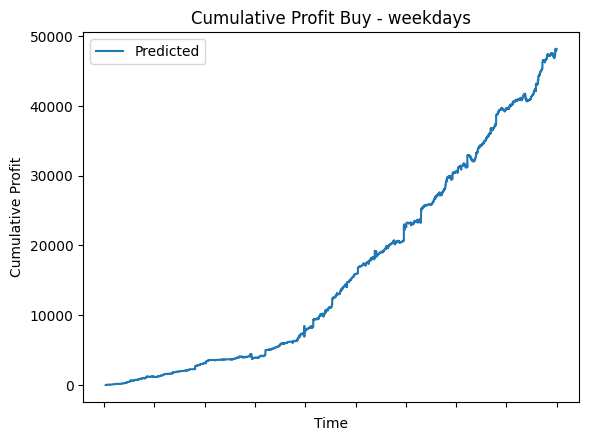

The cumulative profit is 128485.22049466663 with the Real prices


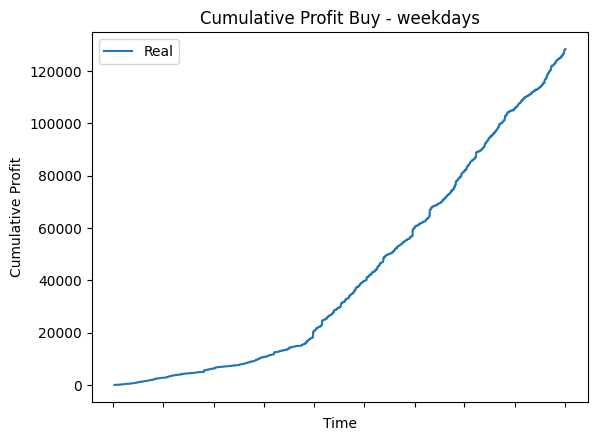

<ipython-input-9-54652e64be67>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sell_pred['Profit_sell'] = df_sell_pred['quantity'] / 100 * (df_sell_pred['price'] - df_sell_pred['real_ID3'])
<ipython-input-9-54652e64be67>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sell_act['Profit_sell'] = df_sell_act['quantity'] / 100 * (df_sell_act['price'] - df_sell_act['real_ID3'])


The cumulative profit is 57710.77935832794 with the Predicted prices


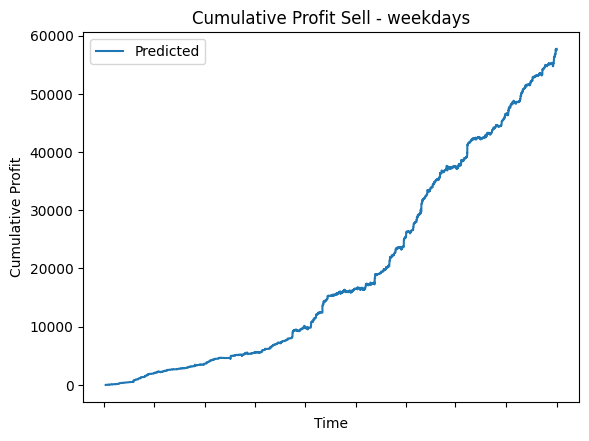

The cumulative profit is 138009.44461944446 with the Real prices


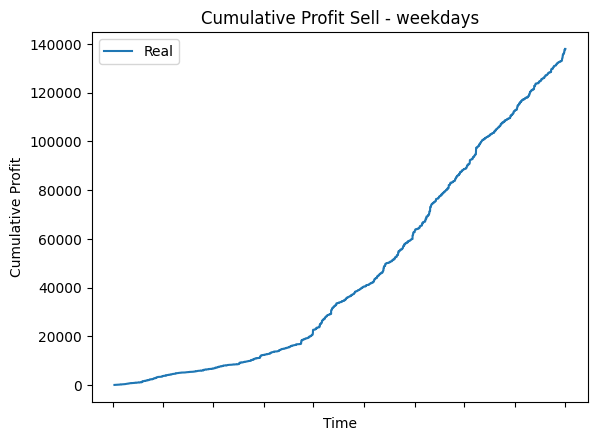

H: 2


<ipython-input-9-54652e64be67>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buy_pred['Profit_buy'] = df_buy_pred['quantity'] / 100 * (df_buy_pred['real_ID3'] - df_buy_pred['price'])
<ipython-input-9-54652e64be67>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buy_act['Profit_buy'] = df_buy_act['quantity'] / 100 * (df_buy_act['real_ID3'] - df_buy_act['price'])


The cumulative profit is 203166.99903768123 with the Predicted prices


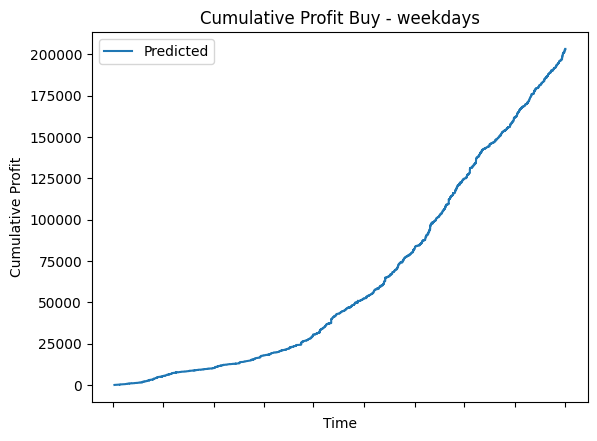

The cumulative profit is 323782.95592316036 with the Real prices


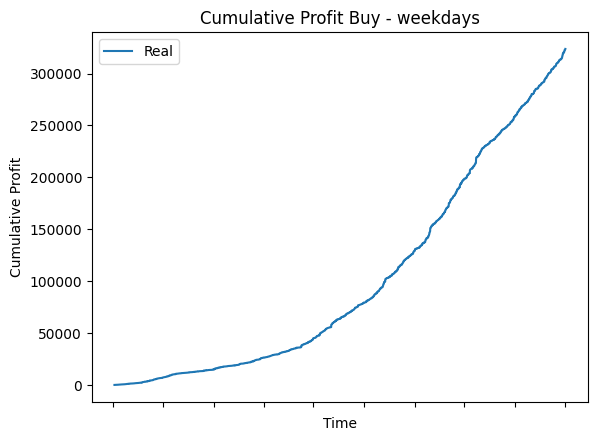

<ipython-input-9-54652e64be67>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sell_pred['Profit_sell'] = df_sell_pred['quantity'] / 100 * (df_sell_pred['price'] - df_sell_pred['real_ID3'])
<ipython-input-9-54652e64be67>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sell_act['Profit_sell'] = df_sell_act['quantity'] / 100 * (df_sell_act['price'] - df_sell_act['real_ID3'])


The cumulative profit is 193684.95950129943 with the Predicted prices


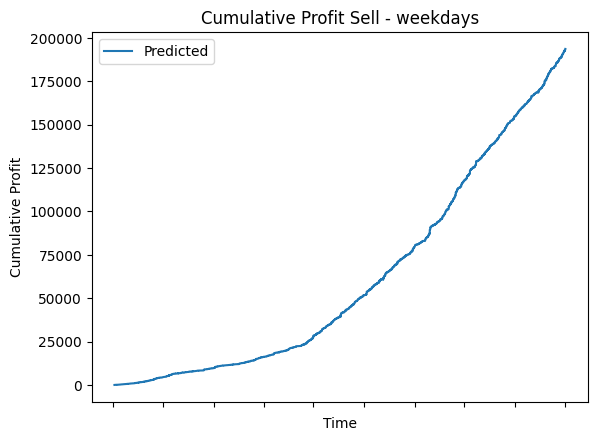

The cumulative profit is 314300.9163867524 with the Real prices


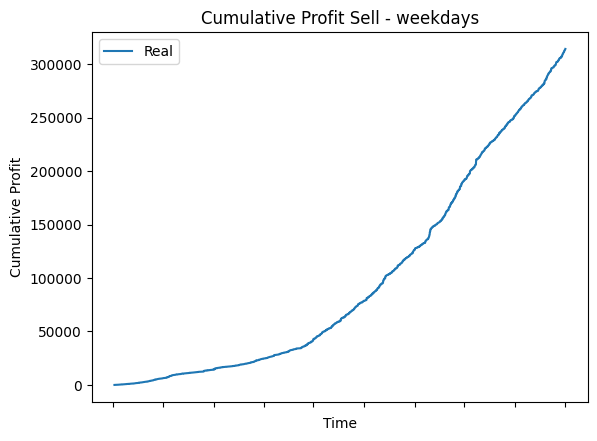

In [22]:
for format in ['weekdays']: #, 'hours']:
  best_models = get_best_models(format, ordner_link, 'RF')
  print(f'Format {format}')
  for H in [3,2]:
    print(f'H: {H}')

    trading_with_id3 = get_trading_df_with_ID3_prices(H, best_models, format, ordner_link, timeseries_orig, trading_df_)

    # pred_id3_vs_real_id3_higher_lower(trading_with_id3, format, H)

    for buy_sell in ['buy', 'sell']:

      [df_pred, df_act] = get_profit_buy_sell(trading_with_id3, buy_sell)

      plot_cumulative_profit(format, buy_sell, df_pred, 'Predicted', H)
      plot_cumulative_profit(format, buy_sell, df_act, 'Real', H)

Compute profit based on ID3 from day before

In [ ]:
# wir berechnen für jedes verschiedene H den erlös, da das sonst zu kompliziert werden würde
def get_trading_df_with_ID3_prices_with_shifted(H, best_models_df, format, ordner_link, timeseries_orig, trading_df):
  """ best_models_df ist der df der aus der funktion get_best_models kommt, er ist wie folgt aufgebaut
  H     test_size  Hyperparamter
  """
  filtered_models_param_H = pd.DataFrame(best_models_df[best_models_df['H']==H])

  # die funktion gibt dir alle trades zurück, die mit iener vorlaufszeit von H bis H-1 gemacht wurden

  trading_df['date_join'] = trading_df['datetime_contract']

  full_df = pd.DataFrame(columns = ['date', 'hour', 'contractName', 'price', 'quantity', 'id', '20', 'YEAR',
       'MONTH', 'DAY', 'HOUR', 'datetime_contract', 'datetime_order',
       'Vorlaufszeit', 'real_ID3', 'shifted_ID3','pred_ID3'])

  timeseries_orig['shifted_ID3'] = timeseries_orig['ID3_filled'].shift(24)


  # nutze die get_predictions funktion aus, um die Predictions zu bekommen für die verschiedenen H
  for arr in best_models_df[format].unique():


    [conn_rf_regr_, cur_rf_regr_] = connect_to_database(f'RF_Regression_test_format_string_{arr}.db', path = ordner_link)

    pred_hyperparam = pd.DataFrame(filtered_models_param_H[filtered_models_param_H[format]==arr])

    # Als Dictionary im Format 'dict'
    dict_format = pred_hyperparam.to_dict(orient='records')

    pred_df = get_predictions(cur_rf_regr_, dict_format[0])

    pred_df_date = add_date(pred_df, timeseries_orig)

    pred_df_date['date_join'] = pd.to_datetime(pred_df_date['date']).dt.tz_localize(None)

    pred_df_date = pd.merge(pred_df_date, timeseries_orig[['date', 'shifted_ID3']], on = 'date', how = 'left' )

    merged_df = pd.merge(trading_df, pred_df_date[['real_ID3','pred_ID3','shifted_ID3', 'date_join']], on='date_join', how='left')

    merged_df = merged_df.dropna(subset=['real_ID3'])

    full_df = pd.concat([full_df, merged_df], ignore_index = True)



  return full_df.reset_index(drop = True)

In [ ]:
for H in [3, 2]:
  ordner_link = f'/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/DecisionTreeRules/RandomForest/Regression'
  best_models = get_best_models('weekdays', ordner_link, 'RF')
  trading_df_H = format_trading_df(trading_df_, H)
  trading_with_id3_shifted = get_trading_df_with_ID3_prices_with_shifted(H, best_models, 'weekdays', ordner_link, timeseries_orig, trading_df_H)

  [df_buy_pred, df_buy_act] = get_profit_buy_sell_shifted(trading_with_id3_shifted.dropna(), 'buy')
  [df_sell_pred, df_sell_act] = get_profit_buy_sell_shifted(trading_with_id3_shifted.dropna(), 'sell')

  break

  df_buy_pred['Profit_buy'].to_excel(f'/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/TradingProfitExcel/buy_id3_shifted_{H}.xlsx')
  df_sell_pred['Profit_sell'].to_excel(f'/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/TradingProfitExcel/sell_id3_shifted_{H}.xlsx')

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


<ipython-input-15-54652e64be67>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buy_pred['Profit_buy'] = df_buy_pred['quantity']/100 * (df_buy_pred['real_ID3'] - df_buy_pred['price'])
<ipython-input-15-54652e64be67>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_buy_act['Profit_buy'] = df_buy_act['quantity']/100 * (df_buy_act['real_ID3'] - df_buy_act['price'])
<ipython-input-15-54652e64be67>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

## For Powerpoint purposes

These code cells are just for the presentation to get a histogramm of the price from a product. You have to load the previous timeseries cells so we can use the timeseries_orig.

In [ ]:
def histogramm_trading_for_specific_hour(df_orig, hour):
  df = df_orig.copy()
  def get_hour(string):
      return int(string[8:])

  df['HOUR'] = df['contractName'].apply(get_hour)

  return df[df['HOUR'] == hour]

In [ ]:
timeseries_orig

,date,YEAR,WEEKDAY,MONTH,HOUR,DUMMY_WEEKDAY,DA_PRC_DAY_BEFORE,DA_AV_PRC_3_DAYS,DA_PRC_SAME_DAY,DA_VOL_DAY_BEFORE,...,FORECAST_WPP,TRADE_COUNT_3_h,TRADE_VOLATILITY_3_h,TRADE_VOLUME_3_h,PRE_ID3_3_h,AV_TRADE_COUNT_3_h,AV_TRADE_VOLATILITY_3_h,AV_TRADE_VOLUME_3_h,AV_PRE_ID3_3_h,ID3_filled
72,2021-01-04T00:00:00+0300,2021,0,1,0,1.0,29.31,29.310000,32.91,5491216.16,...,5977.28,22.0,2.541561,598.0,304.282742,0.000000,0.000000,0.000000,0.000000,314.472183
73,2021-01-04T01:00:00+0300,2021,0,1,1,1.0,26.31,26.310000,29.61,4902162.95,...,5960.58,40.0,5.087838,2262.0,271.443404,0.000000,0.000000,0.000000,0.000000,272.352323
74,2021-01-04T02:00:00+0300,2021,0,1,2,1.0,24.06,24.060000,28.12,4259317.65,...,6193.18,68.0,1.613975,3868.0,256.970988,0.000000,0.000000,0.000000,0.000000,268.413843
75,2021-01-04T03:00:00+0300,2021,0,1,3,1.0,24.21,24.210000,27.21,4051243.38,...,5832.15,94.0,5.741536,4734.0,243.249214,0.000000,0.000000,0.000000,0.000000,251.067629
76,2021-01-04T04:00:00+0300,2021,0,1,4,1.0,23.20,23.200000,25.99,3833004.70,...,5226.30,112.0,8.378759,8644.0,217.738211,9.000000,1.002575,349.000000,207.668166,237.319116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2023-12-31T19:00:00+0300,2023,6,12,19,2.0,81.47,77.440000,76.74,63877502.82,...,2263.99,148.0,59.090058,4954.0,2546.373823,292.666667,96.594646,13036.000000,2353.156359,2618.600941
26276,2023-12-31T20:00:00+0300,2023,6,12,20,2.0,71.71,69.793333,75.90,57274083.90,...,2593.80,176.0,104.388336,9780.0,2412.994031,318.000000,100.417510,8527.333333,2041.751682,2250.737043
26277,2023-12-31T21:00:00+0300,2023,6,12,21,2.0,73.58,77.143333,75.90,56049477.01,...,3090.84,236.0,174.000087,15630.0,2400.335456,391.333333,134.794762,23994.666667,2299.818764,2321.072596
26278,2023-12-31T22:00:00+0300,2023,6,12,22,2.0,74.52,69.636667,55.26,51413236.89,...,3792.24,254.0,82.105814,11872.0,1746.739296,390.666667,136.554608,23306.666667,2139.567234,1749.526633


In [ ]:
# get hour 11-12 from timeseries
hour_11_timeseries_df = timeseries_orig[timeseries_orig['HOUR'] == 11]

In [ ]:
def label_prices_by_quantiles(df, quantile):

    if (1/quantile) % 1 != 0 or quantile >= 1:
      print('Bitte wähle Zahl, sodass diese aufsummiert 1 ergibt')
      return df
    quantiles = np.arange(quantile, 1+  quantile, quantile) * 100

    df = pd.DataFrame(df)
    """
    Labels prices in a DataFrame based on quantiles.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the prices.
    quantiles (list): A list of quantiles to use for labeling.

    Returns:
    pandas.DataFrame: A new DataFrame with the same columns as the input DataFrame,
                      but with an additional column 'price_label' containing the
                      labels for each price.
    """
    # Calculate the quantiles
    q = np.percentile(df['ID3_filled'], quantiles)


    # Create a new column for the labels
    df['Label_ID3'] = 0

    # Label the prices based on the quantiles
    for i, q_val in enumerate(q):
        if i == 0:
            df.loc[df['ID3_filled'] < q_val, 'Label_ID3'] = i + 1
        else:
            df.loc[(df['ID3_filled'] < q_val) & (df['ID3_filled'] > q[i-1]), 'Label_ID3'] = i + 1


    # Return the DataFrame with the labels
    return df, q

In [ ]:
[df, q] = label_prices_by_quantiles(hour_11_timeseries_df, 0.05)
print(q)
# now you can use q to make a nice plot in excel

Get feature selection

In [ ]:
float_str = str(0.2)

# Die letzte Ziffer nach dem Dezimalpunkt extrahieren
last_digit = int(float_str.split('.')[-1][-1])
last_digit

2

In [ ]:
ordner_link = '/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/DecisionTreeRules/RandomForest/Regression'

[conn_rf_regr_, cur_rf_regr_] = connect_to_database(f'RF_Regression_test_format_string_Tuesday.db', path = ordner_link)
table_name_feature = 'Table_H_3_test_size_2_n_estimators_100_max_depth_name_10_min_samples_split_5_min_samples_leaf_2_feature_importance'
feat_df = get_DataFrame_from_SQL_database(cur_rf_regr_, table_name_feature)

In [ ]:
feat_df[0:20]

,Feature,Importance
0,PRE_ID3_3_h,0.992570
1,DOWN_REG_3_h_0,0.000955
2,TRADE_VOLATILITY_3_h,0.000570
3,DA_PRC_SAME_DAY,0.000531
4,DA_VOL_SAME_DAY,0.000453
5,PL_PR_BIO,0.000301
6,UP_REG_3_h_0,0.000280
7,PL_PR_GAS,0.000262
8,DIFF_FOR_GEN_WPP_3_h,0.000234
9,PL_PR_IC,0.000185


Wie viele trades werden durchschnittlich in den letzten 3 stunden vor Lieferung gemacht (Auswertung für die Präsentation)

In [ ]:
df = trading_df_.copy()

def get_year(string):
  return(string[2:4])

df['20'] = '20'
df['YEAR'] = df['contractName'].apply(get_year)
df['YEAR'] = df['20'] + df['YEAR']
df['YEAR'] = df['YEAR'].astype(int)

def get_month(string):
  return int(string[4:6])

df['MONTH'] = df['contractName'].apply(get_month)

def get_day(string):
  return int(string[6:8])

df['DAY'] = df['contractName'].apply(get_day)

def get_hour(string):
  return int(string[8:])

df['HOUR'] = df['contractName'].apply(get_hour)

df['datetime_contract'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR']])

df['datetime_order'] = pd.to_datetime(df['date']).dt.tz_localize(None)

df['Vorlaufszeit'] = df['datetime_contract'] - df['datetime_order']

In [ ]:
id3_trades = df[df['Vorlaufszeit'] <= pd.Timedelta(hours=3)]

In [ ]:
no_id3_trades = df[df['Vorlaufszeit'] > pd.Timedelta(hours=3)]

In [ ]:
id3_trades.groupby(by = ['contractName']).count()['date'].mean()

279.13093695204697

In [ ]:
quant_list = []
for hour in range(0,24):
  print(hour)
  quant_mean = id3_trades[id3_trades['HOUR'] == hour][['contractName', 'quantity']].groupby('contractName').sum().mean()

  quant_list.append(quant_mean.values[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
quant_list_id3 = np.array(quant_list)/100

In [ ]:
pd.DataFrame(quant_list_id3).to_excel('/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/PresentationData/quant_list_id3.xlsx')

In [ ]:
quant_list_no_id3 = []
for hour in range(0,24):
  print(hour)
  quant_mean = no_id3_trades[no_id3_trades['HOUR'] == hour][['contractName', 'quantity']].groupby('contractName').sum().mean()

  quant_list_no_id3.append(quant_mean.values[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
quant_list_no_id3 = np.array(quant_list_no_id3)/100

In [ ]:
pd.DataFrame(quant_list_no_id3).to_excel('/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/PresentationData/quant_list_no_id3.xlsx')

In [ ]:
print('Durchschnittliche Anzahl Trades in den letzten 3 Stunden vor Lieferung:')
print(id3_trades.groupby(by = ['contractName']).count()['date'].mean())
print('Durchschnittliche Anzahl Trades nicht in den letzten 3 Stunden vor Lieferung:')
print(no_id3_trades.groupby(by = ['contractName']).count()['date'].mean())

Durchschnittliche Anzahl Trades in den letzten 3 Stunden vor Lieferung:
279.13093695204697
Durchschnittliche Anzahl Trades nicht in den letzten 3 Stunden vor Lieferung:
202.17241248242047


In [ ]:
id3_trades.groupby(by = ['HOUR']).sum()

In [ ]:
timeseries_orig[['HOUR', 'ID3_filled']].groupby('HOUR').mean().to_excel('/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/PresentationData/ID3_verlauf.xlsx')
timeseries_orig[['HOUR', 'PRE_ID3_3_h']].groupby('HOUR').mean().to_excel('/content/drive/MyDrive/01_Data_AI_SS24/Project_Turkish_Energy_Market/PresentationData/PreID3_verlauf.xlsx')

In [ ]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mean_absolute_percentage_error(timeseries_orig['PRE_ID3_3_h'], timeseries_orig['ID3_filled'])

3997632537486427.0

In [ ]:
((timeseries_orig['ID3_filled'] - timeseries_orig['PRE_ID3_3_h'])/timeseries_orig['ID3_filled']).mean()

-0.019558980659109028